In [99]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import pdb
import json
from shapely.geometry import Point
import seaborn as sns
from tqdm import tqdm
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
low_memory=False
import random
from datetime import datetime


In [209]:
forcast_path = r"C:\Users\drusi\Kaggle\Prosumer\predict-energy-behavior-of-prosumers\forecast_weather.csv"
client_path = r"C:\Users\drusi\Kaggle\Prosumer\predict-energy-behavior-of-prosumers\client.csv"
county_path = r"C:\Users\drusi\Kaggle\Prosumer\predict-energy-behavior-of-prosumers\county_id_to_name_map.json"
county_shp = r"C:\Users\drusi\Kaggle\Prosumer\estonia_administrative_boundaries_level6_counties_polygon\estonia_administrative_boundaries_level6_counties_polygon.shp"

train_path = r"C:\Users\drusi\Kaggle\Prosumer\predict-energy-behavior-of-prosumers\train.csv"
gas_prices_path = r"C:\Users\drusi\Kaggle\Prosumer\predict-energy-behavior-of-prosumers\gas_prices.csv"
electricity_prices_path = r"C:\Users\drusi\Kaggle\Prosumer\predict-energy-behavior-of-prosumers\electricity_prices.csv"
estonia_counties = gpd.read_file(county_shp)

def format_county_name(county_name):
    # Remove ' maakond' and convert to uppercase
    formatted_name = county_name.replace(' maakond', '').upper()
    return formatted_name

# Apply the custom function to the 'county_name' column
estonia_counties['name'] = estonia_counties['name'].apply(format_county_name)
with open(county_path, 'r') as file:
    county_id_to_name_map = json.load(file)

def datestr_to_int_tz(datetime_str):
    return datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S%z').timestamp()

def datestr_to_int(datetime_str):
    return datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S').timestamp()

In [240]:
client_df = pd.read_csv(client_path)
electricity_price_df = pd.read_csv(electricity_prices_path)
gas_price_df = pd.read_csv(gas_prices_path)

In [211]:
electricity_price_df

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1
...,...,...,...,...
15281,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
15282,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
15283,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637
15284,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637


In [233]:

#electricity_price_df['datetime'] = electricity_price_df['datetime'].apply(datestr_to_int)
#electricity_price_df = electricity_price_df.rename(columns={'origin_date': 'datetime'}).dropna()

electricity_price_df = electricity_price_df.drop("forecast_date", axis=1)

In [234]:
electricity_price_df

,euros_per_mwh,datetime,data_block_id
0,92.51,1.630382e+09,1
1,88.90,1.630386e+09,1
2,87.35,1.630390e+09,1
3,86.88,1.630393e+09,1
4,88.43,1.630397e+09,1
...,...,...,...
15281,82.10,1.685401e+09,637
15282,150.85,1.685405e+09,637
15283,82.10,1.685408e+09,637
15284,82.09,1.685412e+09,637


In [245]:
#helper function to convert datetime strings to integers representing a time year-month-day hour-min-sec
from datetime import datetime
def datestr_to_int(datetime_str,date_format):
    return datetime.strptime(datetime_str, date_format).timestamp()
# train['datetime'] = train['datetime'].apply(lambda x: datestr_to_int(x,'%Y-%m-%d %H:%M:%S'))
#convert date strings to ints
gas_price_df['forecast_date'] = gas_price_df['forecast_date'].apply(lambda x: datestr_to_int(x,'%Y-%m-%d'))
gas_price_df['origin_date'] = gas_price_df['origin_date'].apply(lambda x: datestr_to_int(x,'%Y-%m-%d'))


TypeError: strptime() argument 1 must be str, not float

In [247]:
electricity_price_df['forecast_date'] = electricity_price_df['forecast_date'].apply(lambda x: datestr_to_int(x,'%Y-%m-%d %H:%M:%S'))
electricity_price_df['origin_date'] = electricity_price_df['origin_date'].apply(lambda x: datestr_to_int(x,'%Y-%m-%d %H:%M:%S'))

In [249]:
gas_price_df

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,1.630469e+09,45.23,46.32,1.630382e+09,1
1,1.630555e+09,45.62,46.29,1.630469e+09,2
2,1.630642e+09,45.85,46.40,1.630555e+09,3
3,1.630728e+09,46.30,46.80,1.630642e+09,4
4,1.630814e+09,46.30,46.58,1.630728e+09,5
...,...,...,...,...,...
632,1.685074e+09,29.10,34.10,1.684987e+09,633
633,1.685160e+09,28.30,34.10,1.685074e+09,634
634,1.685246e+09,28.10,34.10,1.685160e+09,635
635,1.685333e+09,28.16,36.98,1.685246e+09,636


In [214]:
county_name_to_id_map = {value.replace('MAA', ''): int(key) for key, value in county_id_to_name_map.items()}

county_name_to_id_map

{'HARJU': 0,
 'HIIU': 1,
 'IDA-VIRU': 2,
 'JÄRVA': 3,
 'JÕGEVA': 4,
 'LÄÄNE-VIRU': 5,
 'LÄÄNE': 6,
 'PÄRNU': 7,
 'PÕLVA': 8,
 'RAPLA': 9,
 'SAARE': 10,
 'TARTU': 11,
 'UNKNOWN': 12,
 'VALGA': 13,
 'VILJANDI': 14,
 'VÕRU': 15}

In [215]:
forcast_df = pd.read_csv(forcast_path)
forcast_df

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 00:00:00+00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 00:00:00+00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 00:00:00+00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 00:00:00+00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0


In [216]:
# Create a GeoDataFrame from the DataFrame
geometry = [Point(xy) for xy in zip(forcast_df['longitude'], forcast_df['latitude'])]
forecast_gdf = gpd.GeoDataFrame(forcast_df, geometry=geometry, crs=estonia_counties.crs)
forecast_gdf ['origin_datetime'] = forecast_gdf ['origin_datetime'].apply(datestr_to_int_tz)

In [217]:
forecast_gdf

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,geometry
0,57.6,21.7,1.630454e+09,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,POINT (21.70000 57.60000)
1,57.6,22.2,1.630454e+09,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,POINT (22.20000 57.60000)
2,57.6,22.7,1.630454e+09,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,POINT (22.70000 57.60000)
3,57.6,23.2,1.630454e+09,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,POINT (23.20000 57.60000)
4,57.6,23.7,1.630454e+09,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,POINT (23.70000 57.60000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,1.685405e+09,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0,POINT (26.20000 59.70000)
3424508,59.7,26.7,1.685405e+09,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0,POINT (26.70000 59.70000)
3424509,59.7,27.2,1.685405e+09,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0,POINT (27.20000 59.70000)
3424510,59.7,27.7,1.685405e+09,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0,POINT (27.70000 59.70000)


In [218]:
# estonia_counties = estonia_counties.drop(["admin_leve", "boundary", "z_order", "way_area"], axis=1)
estonia_counties


,admin_leve,boundary,name,z_order,way_area,geometry
0,6,administrative,JÕGEVA,0,1.068780e+10,"POLYGON ((25.75064 58.61256, 25.75091 58.61265..."
1,6,administrative,IDA-VIRU,0,1.727120e+10,"POLYGON ((26.70233 59.35907, 26.71536 59.36877..."
2,6,administrative,VÕRU,0,9.812330e+09,"POLYGON ((26.37095 57.87577, 26.37112 57.87583..."
3,6,administrative,TARTU,0,1.458430e+10,"POLYGON ((26.05201 58.09114, 26.05202 58.09162..."
4,6,administrative,RAPLA,0,1.034720e+10,"POLYGON ((24.07063 58.96884, 24.08336 58.97342..."
5,6,administrative,JÄRVA,0,9.998450e+09,"POLYGON ((25.04455 58.75748, 25.04491 58.75905..."
6,6,administrative,HARJU,0,3.095040e+10,"POLYGON ((23.52167 59.48167, 23.73493 59.52863..."
7,6,administrative,LÄÄNE,0,1.583310e+10,"POLYGON ((22.73333 59.29167, 22.91966 59.37375..."
8,6,administrative,LÄÄNE-VIRU,0,2.157980e+10,"POLYGON ((25.53639 59.26304, 25.53641 59.26309..."
9,6,administrative,VALGA,0,6.782940e+09,"POLYGON ((25.58046 57.94421, 25.58077 57.94441..."


In [ ]:
ax = estonia_counties.plot(figsize=(10, 8), alpha=0.5, edgecolor='k')

# Plotting the points on top of the counties
forecast_gdf.plot(ax=ax, marker='o', color='red', markersize=50)

# # Adding basemap underneath
# basemap, extent = ctx.bounds2img(*estonia_counties.total_bounds, zoom=8, source=ctx.providers.Stamen.TonerLite)
# ax.imshow(basemap, extent=extent, alpha=0.5)

# Set the title
plt.title('Points on Top of Estonia Counties with Basemap')

# Show the plot
plt.show()

In [220]:
# Perform a spatial join to associate each point in forecast_gdf with a county
forecast_with_counties = gpd.sjoin(forcast_gdf, estonia_counties, how="left", predicate="within").dropna()
forecast_with_counties

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,...,surface_solar_radiation_downwards,snowfall,total_precipitation,geometry,index_right,admin_leve,boundary,name,z_order,way_area
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,...,0.0,0.0,0.0,POINT (23.20000 57.60000),15.0,6,administrative,SAARE,0.0,4.476180e+10
10,57.6,26.7,2021-09-01 00:00:00+00:00,1,9.876489,9.120386,0.000000,0.025940,0.003006,0.026001,...,0.0,0.0,0.0,POINT (26.70000 57.60000),2.0,6,administrative,VÕRU,0.0,9.812330e+09
11,57.6,27.2,2021-09-01 00:00:00+00:00,1,10.815576,10.046899,0.747406,0.083191,0.000000,0.761780,...,0.0,0.0,0.0,POINT (27.20000 57.60000),2.0,6,administrative,VÕRU,0.0,9.812330e+09
14,57.9,21.7,2021-09-01 00:00:00+00:00,1,16.050439,12.355493,0.886078,0.051636,0.000092,0.889587,...,0.0,0.0,0.0,POINT (21.70000 57.90000),15.0,6,administrative,SAARE,0.0,4.476180e+10
15,57.9,22.2,2021-09-01 00:00:00+00:00,1,14.418481,11.374536,0.855011,0.003052,0.000015,0.855301,...,0.0,0.0,0.0,POINT (22.20000 57.90000),15.0,6,administrative,SAARE,0.0,4.476180e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424504,59.7,24.7,2023-05-30 00:00:00+00:00,48,9.948633,4.530542,0.300537,0.000931,0.002350,0.302399,...,0.0,0.0,0.0,POINT (24.70000 59.70000),6.0,6,administrative,HARJU,0.0,3.095040e+10
3424505,59.7,25.2,2023-05-30 00:00:00+00:00,48,10.035303,4.862695,0.197937,0.170959,0.000000,0.336334,...,0.0,0.0,0.0,POINT (25.20000 59.70000),6.0,6,administrative,HARJU,0.0,3.095040e+10
3424506,59.7,25.7,2023-05-30 00:00:00+00:00,48,10.039697,5.234888,0.184570,0.196976,0.000000,0.348114,...,0.0,0.0,0.0,POINT (25.70000 59.70000),6.0,6,administrative,HARJU,0.0,3.095040e+10
3424507,59.7,26.2,2023-05-30 00:00:00+00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,...,0.0,0.0,0.0,POINT (26.20000 59.70000),8.0,6,administrative,LÄÄNE-VIRU,0.0,2.157980e+10


In [221]:
# The resulting GeoDataFrame will have a new column 'index_right' containing the index of the matching county
# Rename this column to 'county' and select only the necessary columns
forecast_with_counties = forecast_with_counties.rename(columns={'index_right': 'county'})
forecast_with_counties.dropna(inplace=True)
forecast_with_counties["origin_datetime"] = forecast_with_counties["origin_datetime"].apply(datestr_to_int_tz)
forecast_with_counties = forecast_with_counties.drop("forecast_datetime")


KeyError: "['forecast_datetime'] not found in axis"

In [ ]:
forecast_with_counties

In [222]:
avg_weather_df = forecast_with_counties.groupby(['county', 'origin_datetime']).agg({
    'cloudcover_high': 'mean',
    'cloudcover_low': 'mean',
    'cloudcover_mid': 'mean',
    'cloudcover_total': 'mean',
    'direct_solar_radiation': 'mean', 
    'surface_solar_radiation_downwards': 'mean',
    'snowfall': 'mean',
    'total_precipitation': 'mean'
}).reset_index()
avg_weather_df['county'] = avg_weather_df['county'].astype(int)
avg_weather_df = avg_weather_df.rename(columns={'name': 'county', 'origin_datetime': 'datetime'}).dropna()
# Rename origin_datetime column to datetime so I can merge with other


In [251]:
train_data

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60


In [262]:
random.seed(4321)
train_data = pd.read_csv(r"C:\Users\drusi\Kaggle\Prosumer\predict-energy-behavior-of-prosumers\train.csv")
train_data["datetime"] = train_data["datetime"].apply(datestr_to_int, date_format="%Y-%m-%d %H:%M:%S")



In [263]:
train_data

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,1.630469e+09,0,0,0
1,0,0,1,96.590,1,1.630469e+09,0,1,0
2,0,0,2,0.000,0,1.630469e+09,0,2,1
3,0,0,2,17.314,1,1.630469e+09,0,3,1
4,0,0,3,2.904,0,1.630469e+09,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,1.685588e+09,637,2018347,64
2018348,15,1,1,0.000,0,1.685588e+09,637,2018348,59
2018349,15,1,1,28.404,1,1.685588e+09,637,2018349,59
2018350,15,1,3,0.000,0,1.685588e+09,637,2018350,60


In [267]:
# TODO MERGE ALL THE DATASETS
# Lambda function to randomely sample the csv since its too large to work with efficiently
# train_data = pd.read_csv(r"C:\Users\drusi\Kaggle\Prosumer\predict-energy-behavior-of-prosumers\train.csv", skiprows=lambda x: x > 0 and random.random() >=0.01)
#train_data = train_data.drop(["prediction_unit_id", "row_id"], axis=1)
# train_data = train_data.merge(client_df, on=['county', 'data_block_id', "is_business", "product_type"], how='left').dropna()

# train_data = train_data.merge(gas_price_df, left_on='datetime',right_on='forecast_date', how='left').dropna()
# train_data = train_data.merge(avg_weather_df, left_on=['county','datetime'], how='left').dropna()
# #train_data = train_data.merge(electricity_price_df, left_on='datetime', right_on="forecast_date", how='left').dropna()
# train_data


ValueError: len(right_on) must equal len(left_on)

In [265]:
train_data

,county,is_business,product_type,target,is_consumption,datetime,data_block_id_x,row_id,prediction_unit_id,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id_y
0,0,0,1,0.713,0,1.630469e+09,0,0,0,1.630469e+09,45.23,46.32,1.630382e+09,1.0
1,0,0,1,96.590,1,1.630469e+09,0,1,0,1.630469e+09,45.23,46.32,1.630382e+09,1.0
2,0,0,2,0.000,0,1.630469e+09,0,2,1,1.630469e+09,45.23,46.32,1.630382e+09,1.0
3,0,0,2,17.314,1,1.630469e+09,0,3,1,1.630469e+09,45.23,46.32,1.630382e+09,1.0
4,0,0,3,2.904,0,1.630469e+09,0,4,2,1.630469e+09,45.23,46.32,1.630382e+09,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012237,15,1,0,181.786,1,1.685419e+09,636,2012237,64,1.685419e+09,29.00,34.00,1.685333e+09,637.0
2012238,15,1,1,0.000,0,1.685419e+09,636,2012238,59,1.685419e+09,29.00,34.00,1.685333e+09,637.0
2012239,15,1,1,28.832,1,1.685419e+09,636,2012239,59,1.685419e+09,29.00,34.00,1.685333e+09,637.0
2012240,15,1,3,0.000,0,1.685419e+09,636,2012240,60,1.685419e+09,29.00,34.00,1.685333e+09,637.0


Mean Squared Error (MSE): 6408.6741887811295
Root Mean Squared Error (RMSE): 80.05419532280072
Mean Absolute Error (MAE): 19.6563817315708
R-squared (R2): 0.9883537915249166
Explained Variance Score (EVS): 0.9883539600591034
Mean Squared Logarithmic Error (MSLE): 0.05233046074800856


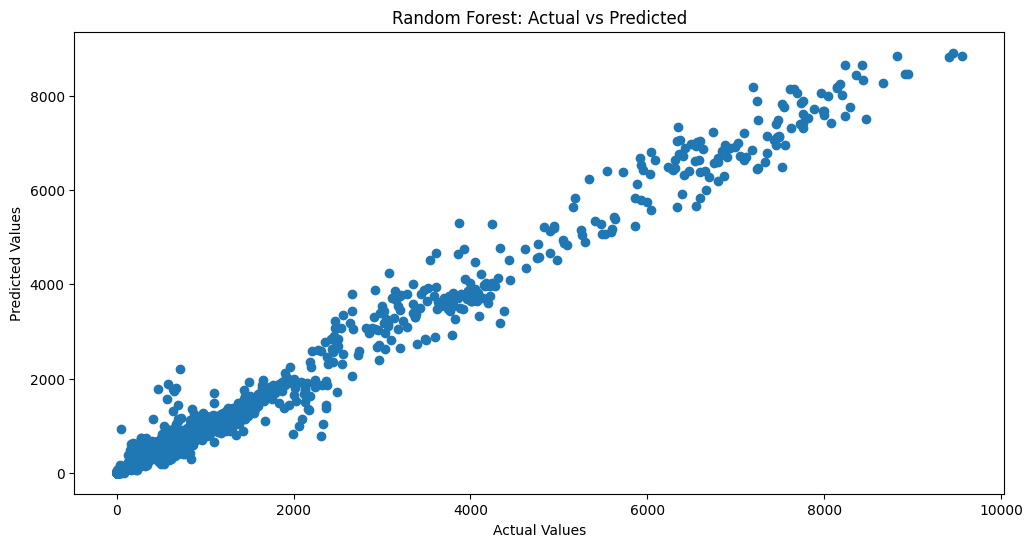

In [266]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_squared_log_error
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = train_data
# Assuming your DataFrame is named df
# Select relevant columns for modeling
y_rf = df['target']
X_rf = df.drop(['target'], axis=1)
# Split the data into training and testing sets for the Random Forest model
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Fit a Random Forest model directly on the target variable
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Make predictions on the test set
predictions_rf = rf_model.predict(X_test_rf)

# Evaluate the Random Forest model using metrics
mse_rf = mean_squared_error(y_test_rf, predictions_rf)
rmse_rf = mean_squared_error(y_test_rf, predictions_rf, squared=False)
mae_rf = mean_absolute_error(y_test_rf, predictions_rf)
r2_rf = r2_score(y_test_rf, predictions_rf)
evs_rf = explained_variance_score(y_test_rf, predictions_rf)
msle_rf = mean_squared_log_error(y_test_rf, predictions_rf)

# Print Regression Metrics
print(f'Mean Squared Error (MSE): {mse_rf}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf}')
print(f'Mean Absolute Error (MAE): {mae_rf}')
print(f'R-squared (R2): {r2_rf}')
print(f'Explained Variance Score (EVS): {evs_rf}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle_rf}')

# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test_rf, predictions_rf)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted')
plt.show()

